<h1>Emotion Prediction using CNN</h1>

# Data Handling

In [ ]:
# Mounting the Dataset files from Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Unzip a Zip file using python

import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Face_Recognition/FER_2013_all.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/Face_Recognition/')
zip_ref.close()


In [ ]:
# Imporing all the various Libraries used
import math
import os
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.utils as np_utils

In [ ]:
# Importing the Datset and reading the csv Document
df = pd.read_csv('/content/drive/MyDrive/Face_Recognition/fer2013/fer2013/fer2013.csv')

print(df.shape) # Shape of the Datset that is in CSV file
df.head() # Printing the first 5 Vales of the CSV file

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# Finding all the Unique Vales where each associate to a Particular Emotion
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
# Data present in each Class of Emotion
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

So majority classes belongs to <br/>
3:Happy | 4:Sad | 6:Neutral <br />
We are also intersted in these three main classes only.

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

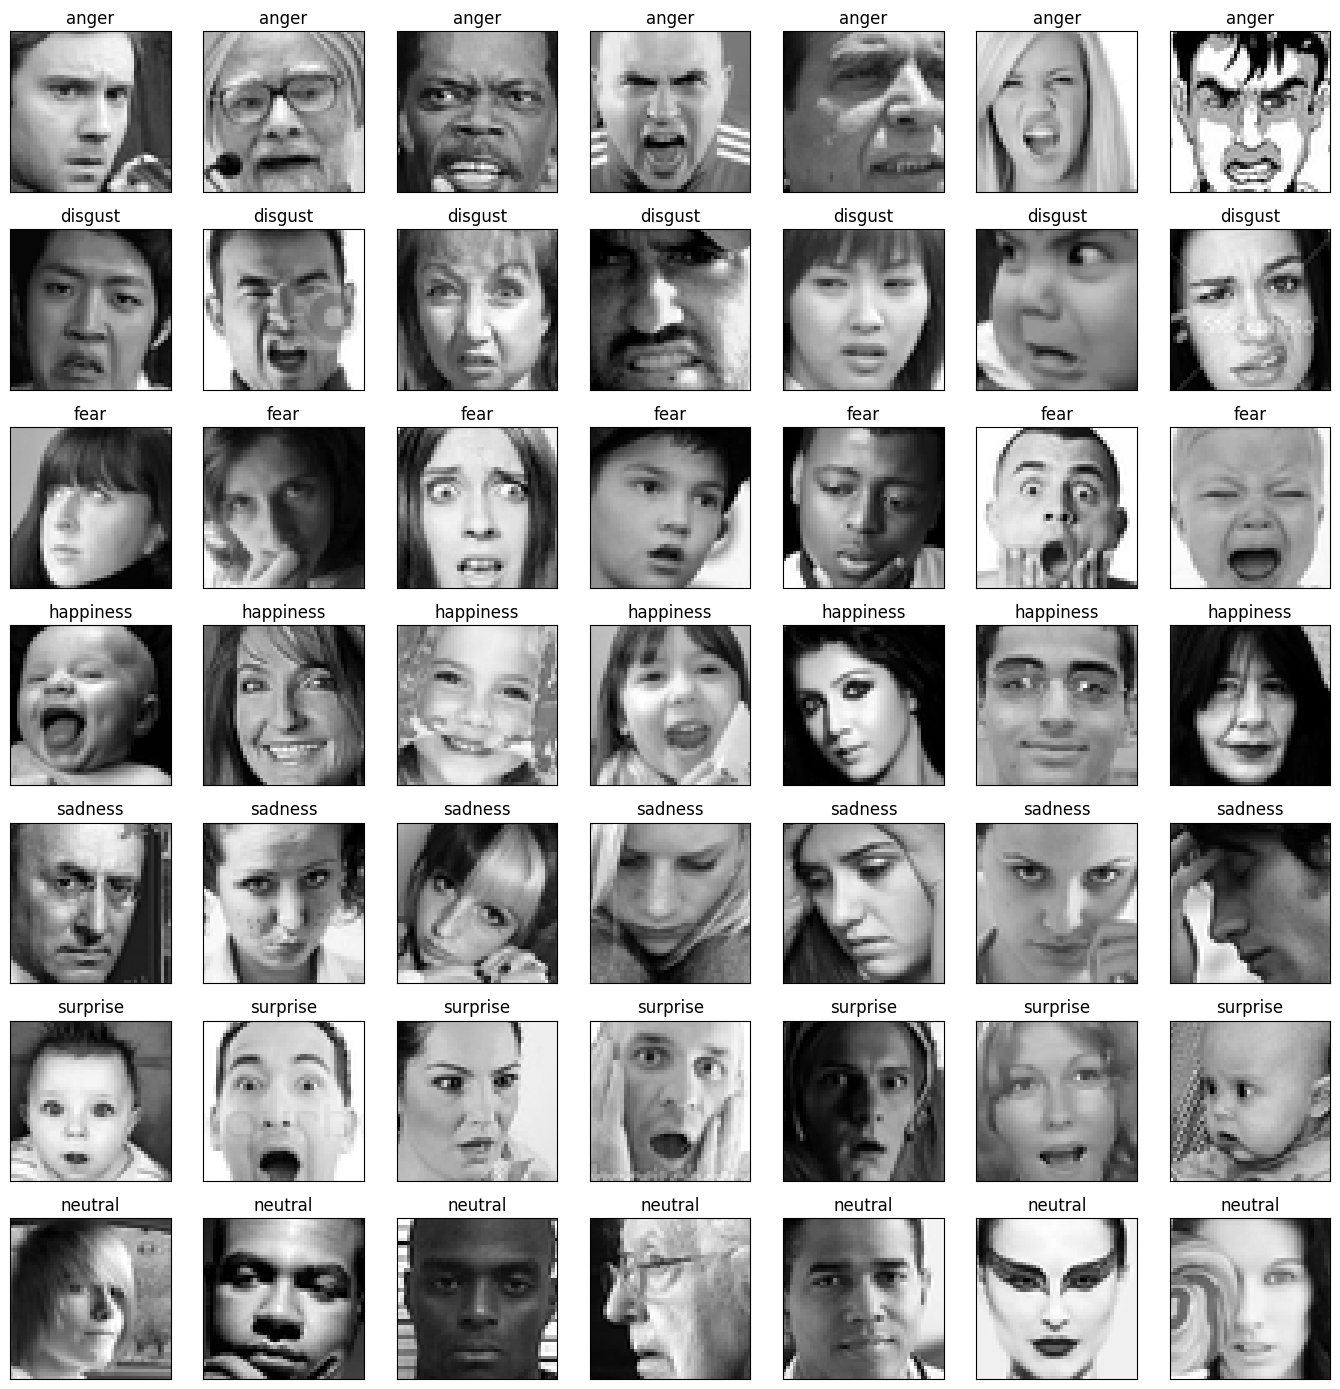

In [ ]:
# Plotting the Images from the Dataset for each Emotion
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
# Intrested Emotions associated Label
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
print(df.shape)
df.head()

(21264, 3)


,emotion,pixels,Usage
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


To make the data compatible for neural networks we will do Data Processing

In [ ]:
# We can see thet the Pixels is a String of numbers
type(df.pixels.iloc[0])

str

In [ ]:
# Processing the String of numbers into an Numpy Array
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

In [ ]:
# This is used to Stack all the Array Layers onto each other
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(21264, 48, 48, 1)

In [ ]:
img_array[0]

array([[[ 24.],
        [ 32.],
        [ 36.],
        ...,
        [173.],
        [172.],
        [173.]],

       [[ 25.],
        [ 34.],
        [ 29.],
        ...,
        [173.],
        [172.],
        [173.]],

       [[ 26.],
        [ 29.],
        [ 25.],
        ...,
        [172.],
        [172.],
        [174.]],

       ...,

       [[159.],
        [185.],
        [157.],
        ...,
        [157.],
        [156.],
        [153.]],

       [[136.],
        [157.],
        [187.],
        ...,
        [152.],
        [152.],
        [150.]],

       [[145.],
        [130.],
        [161.],
        ...,
        [142.],
        [143.],
        [142.]]], dtype=float32)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
img_labels[0]

array([0., 1., 0.], dtype=float32)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


## Splitting of Data

Splitting the data into Training and Validation set

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
# Cleaning of The Memory
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
# Setting the random seed for having a same generalised output
np.random.seed(42)

# Model Designing

In [ ]:
# Building a Sequential CNN Model
def build_model(optim):
    model = Sequential(name='DCNN')

    # 1st Layer
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

    # 2nd Layer
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )

    model.add(BatchNormalization(name='batchnorm_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.2, name='dropout_2'))

    # 3rd Layer
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )

    # 4th Layer
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )

    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
    model.add(Dropout(0.2, name='dropout_4'))

    # 5th Layer
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    model.add(BatchNormalization(name='batchnorm_5'))

    # 6th Layer
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )

    model.add(BatchNormalization(name='batchnorm_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_6'))
    model.add(Dropout(0.2, name='dropout_6'))

    # Flatten The Layers to feed into a Dense Layer
    model.add(Flatten(name='flatten'))


    # Adding Dense Layers in the End of the CNN
    # 7th Layer
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_7'))

    model.add(Dropout(0.6, name='dropout_7'))

    # Last Layer / Output Later
    # Using Softmax Activation as we have 3 class categorie that our model has to classify to
    model.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    # Compiling all the Layers of the Model with a Loss Function
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    model.summary()

    return model

In [ ]:
"""
Two callbacks are used:
1: `early stopping` for avoiding overfitting training data
2: `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is used to increase the Dataset
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
# Setting Hyper-Parameters
# A batch size of 32 performs the best
batch_size = 32
epochs = 100
optims = [
    optimizers.Adam(0.001),
]

In [ ]:
# Calling our build_model function to start building our Model
model = build_model(optims[0])

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 24, 24, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 12, 12, 64)        0      

## Traning the Model

In [ ]:
# Provideing data to the Model to Train abd Validate on
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
598/598 [==============================] - 39s 47ms/step - loss: 1.3172 - accuracy: 0.4077 - val_loss: 0.9940 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 2/100
598/598 [==============================] - 26s 44ms/step - loss: 0.9598 - accuracy: 0.5321 - val_loss: 0.8232 - val_accuracy: 0.6159 - lr: 0.0010
Epoch 3/100
598/598 [==============================] - 27s 45ms/step - loss: 0.8352 - accuracy: 0.6047 - val_loss: 0.7519 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 4/100
598/598 [==============================] - 30s 50ms/step - loss: 0.7624 - accuracy: 0.6530 - val_loss: 0.6720 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 5/100
598/598 [==============================] - 26s 44ms/step - loss: 0.7164 - accuracy: 0.6757 - val_loss: 0.8174 - val_accuracy: 0.6681 - lr: 0.0010
Epoch 6/100
598/598 [==============================] - 25s 41ms/step - loss: 0.6976 - accuracy: 0.6880 - val_loss: 0.6948 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 7/100
598/598 [==============================]

In [ ]:
# Saving the model to use it again without needing to train it again
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation

## Plotting of Data and Reviewing our Models Performance

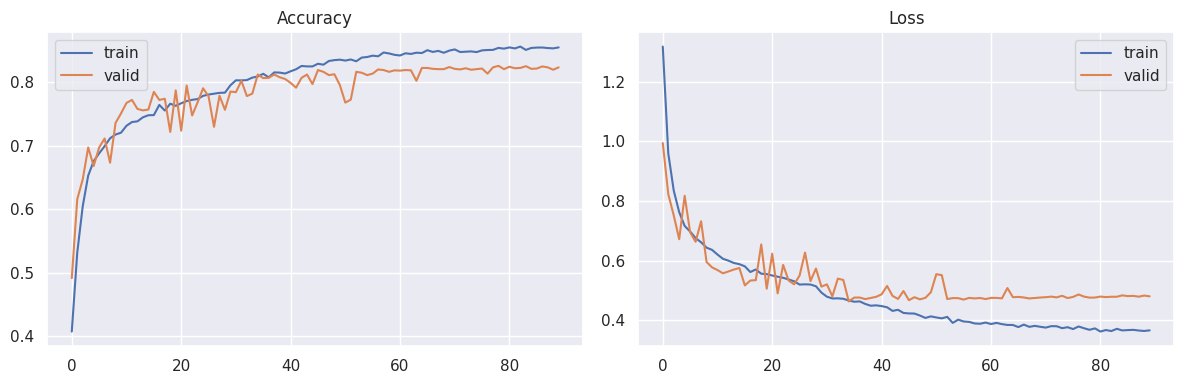

In [ ]:
# Plotting of Data
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

67/67 [==============================] - 1s 12ms/step


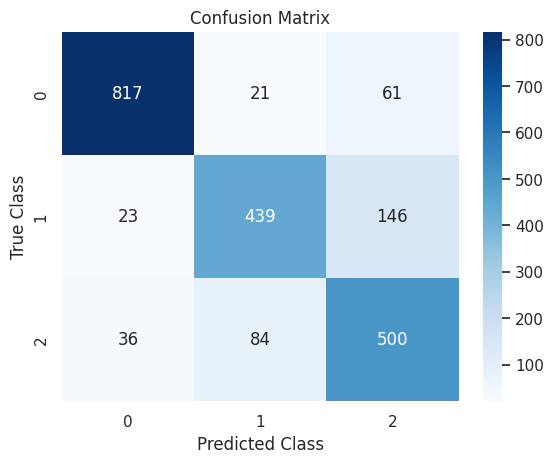

In [ ]:
# prompt: plot a confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the predictions from the model
y_pred = model.predict(X_valid)

# Convert the predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = np.argmax(y_valid, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


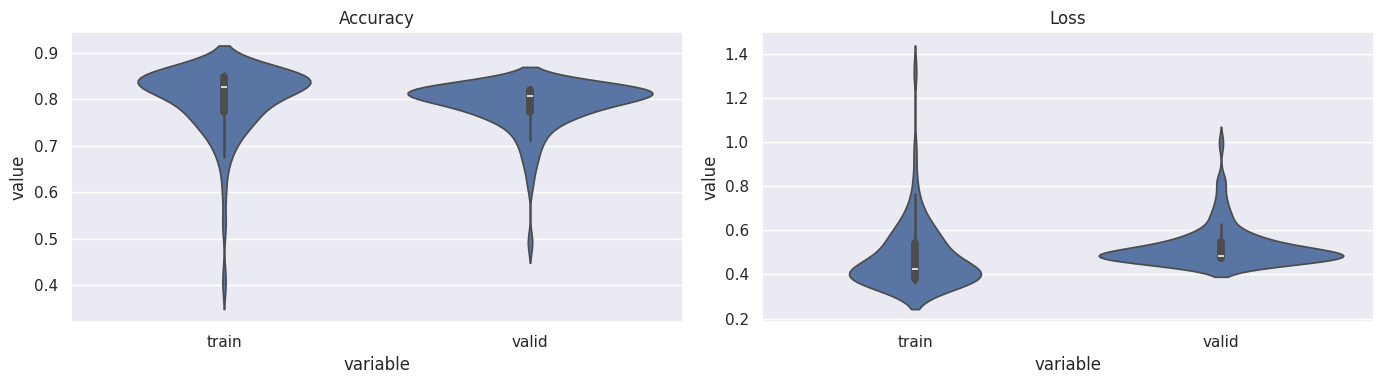

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu))
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss))
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [ ]:
from sklearn import metrics as sk

The confusion matrix clearly shows that our model is doing a good job on the class `happy` but it's performance is low on other two classes.<br />

One of the reason for this could be the fact that these two classes have less data. But when the images were examined we found taht some of the images from these two classes are even hard for a human to tell, whether a person is sad or neutral.<br />

Facial expression depends on each individual. Some people may have the same face for neutral face that looks like a sad face.

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 [==============================] - 0s 30ms/step


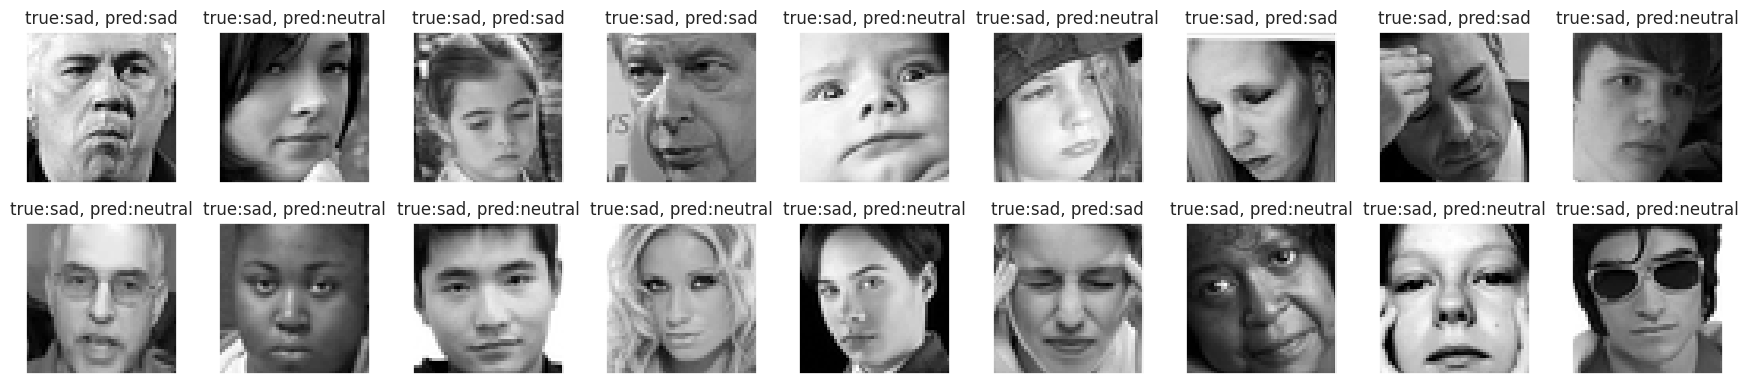

In [ ]:
# Taking Random Data from the Dataset and giving it to our tarined model to see the Output the Model provides us with
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        pyplot.tight_layout()

We can see that in the first row `9th image` looks more like neutral rather than sad and our model even predicted it as neutral. <br />
Whereas in the second row we can see that many images are hard to distinguish between `Sad` and `Neutral` facial Emotions.

# Conclusion

Our Model has an Accuracy of **85.46 %** <br />
The model predicts 3 main Classes of Facial Emotions:
*   Sad
*   Happy
*   Neutral
<br />
based on CNN(Convolutional Neural Network) Model with Softmax Activation


